In [1]:
import dagstermill

In [2]:
from dagster import ModeDefinition, ResourceDefinition
from collections import namedtuple

url = 'postgresql://{username}:{password}@{hostname}:5432/{db_name}'.format(
    username='test', password='test', hostname='localhost', db_name='test'
)
DbInfo = namedtuple('DbInfo', 'url')
context = dagstermill.get_context(
    mode_def=ModeDefinition(
        resource_defs={'db_info': ResourceDefinition(lambda _: DbInfo(url))}
    )
)

table_name = 'delays_vs_fares'

In [ ]:
db_url = context.resources.db_info.url

In [3]:
import os

import sqlalchemy as sa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dagster.utils import mkdir_p

In [4]:
engine = sa.create_engine(db_url)

/Users/max/.virtualenvs/dagster/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [5]:
from matplotlib.backends.backend_pdf import PdfPages
plots_path = os.path.join(os.getcwd(), 'plots')
mkdir_p(plots_path)
pdf_path = os.path.join(plots_path, 'fares_vs_delays.pdf')
pp = PdfPages(pdf_path)

In [6]:
fares_vs_delays = pd.read_sql('select * from {table_name}'.format(table_name=table_name), engine)

In [7]:
fares_vs_delays.head()

,origin,dest,avg_fare,avg_fare_per_mile,avg_arrival_delay,avg_departure_delay
0,SFO,IND,434.767524,0.142556,4.730924,11.188755
1,SFO,CVG,489.184236,0.146830,-6.628049,4.054545
2,SFO,MSY,498.145642,0.152935,-6.733871,6.397590
3,SFO,SEA,368.674415,0.237027,13.233090,12.270567
4,SFO,OKC,428.348442,0.186265,10.461538,15.736264


In [8]:
fares_vs_delays['avg_arrival_delay'].describe()

count    84.000000
mean      7.319261
std      11.965286
min     -19.000000
25%       2.347601
50%       7.380119
75%      11.461447
max      93.090909
Name: avg_arrival_delay, dtype: float64

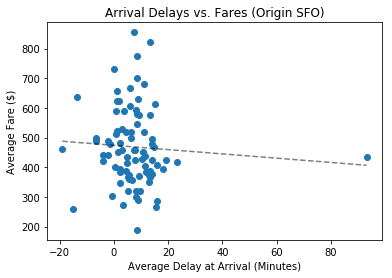

In [9]:
plt.scatter(fares_vs_delays['avg_arrival_delay'], fares_vs_delays['avg_fare'])

try:
    z = np.polyfit(fares_vs_delays['avg_arrival_delay'], fares_vs_delays['avg_fare'], 1)
    f = np.poly1d(z)

    x_fit = np.linspace(fares_vs_delays['avg_arrival_delay'].min(), fares_vs_delays['avg_arrival_delay'].max(), 50)
    y_fit = f(x_fit)
    plt.plot(x_fit, y_fit, 'k--', alpha=0.5)
except:
    pass

plt.title('Arrival Delays vs. Fares (Origin SFO)')
plt.xlabel('Average Delay at Arrival (Minutes)')
plt.ylabel('Average Fare ($)')
pp.savefig()

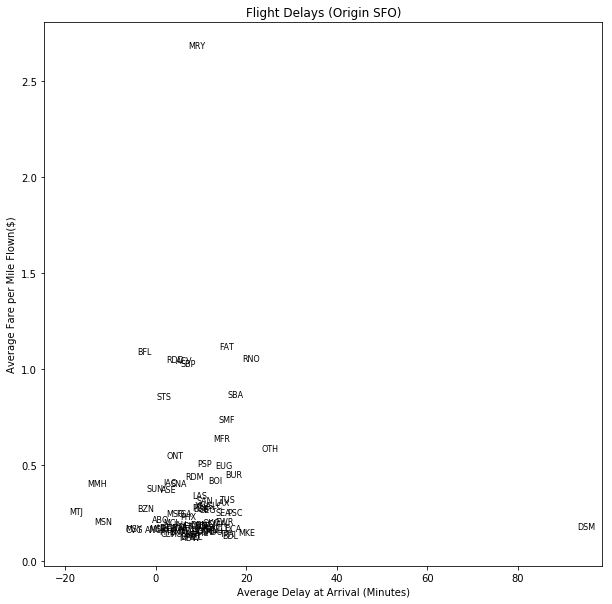

In [10]:
fig, ax = plt.subplots(figsize=(10,10))

for i, _ in enumerate(fares_vs_delays.index):
    plt.text(
        fares_vs_delays['avg_arrival_delay'][i],
        fares_vs_delays['avg_fare_per_mile'][i],
        fares_vs_delays['dest'][i],
        fontsize=8)

plt.scatter(fares_vs_delays['avg_arrival_delay'], fares_vs_delays['avg_fare_per_mile'], alpha=0)
plt.title('Flight Delays (Origin SFO)')
plt.xlabel('Average Delay at Arrival (Minutes)')
plt.ylabel('Average Fare per Mile Flown($)')

pp.savefig()

In [11]:
pp.close()

In [ ]:
from dagster import LocalFileHandle
dagstermill.yield_result(LocalFileHandle(pdf_path))